In [1]:
import numpy as np
from scipy.integrate import *
from numpy.fft import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.ticker import ScalarFormatter

In [2]:
def diffeq(X,t, params):
  """
  A modell: R sugarú körön egyenletesen elrendezett golyók összekötve valamilyen rugóval.
  Körülöttük egy másik golyó halad.

  Bemenetnek kapja egy array-ben:
  - kezdeti szögeket (belső és külső)
  - kezdeti szögsebességeket

  Külön pedig néhány paramétert (sorban):
  - rugóállandó (d)
  - tömegek (m)
  - kör sugara (R)
  - külső kör sugara (rho)
  - külső kölcsönhatás (k)
  - kölcsönhatás távolságfüggését szabályzó paraméter (b)
  """

  N=int((len(X)-2)/2)
  d,m,R,rho,k,b=params  #bejövő paraméterek
  l=2*R*np.sin(np.pi/(N)) #rugók nyugalmi hossza

  phi = np.array(X[:N]) #első N darab elem a szögek
  omega = np.array(X[N:2*N])  #második N darab a szögsebességek
  theta = np.array([X[-2]]) #utolsó előtti elem a kezdeti szög
  Omega = np.array([X[-1]]) #utolsó a szögsebessége

  phi_m1 = np.roll(phi,-1)
  phi_p1 = np.roll(phi,1)

  #belső golyók szöggyorsulása:
  beta = (d/(m*R)) * ( R*np.sin(phi_m1-phi) -
                       R*np.sin(phi-phi_p1) +
                      (np.sqrt(2)*l*np.sin(phi - phi_p1))/(2*np.sqrt(1-np.cos(phi-phi_p1))) -
                      (np.sqrt(2)*l*np.sin(phi_m1 - phi))/(2*np.sqrt(1-np.cos(phi_m1-phi))) -
                       (rho*k*b/(d))*((np.exp( -b*np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2))*np.sin(theta - phi)) /
                      (np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2 )))
                     )


  #külső golyó szöggyorsulása:
  Beta = np.array([((R*k*b)/(m*rho)) * np.sum(np.exp( -b*np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2))*np.sin(theta - phi)
                                  / np.sqrt(R**2 - 2*R*rho*np.cos(theta - phi) + rho**2 ))])

  U = np.concatenate((omega, beta, Omega, Beta))

  return U

In [3]:
n=100 #golyók száma
s=200 #időfelosztás
T=200 #vizsgált időintervallum

In [4]:
t=np.linspace(0,T,s)

In [5]:
d=1 #"rugóállandó"
m=1 #tömegek
R=1 #"kör" sugara
rho=1.1 #külső kör sugara
k=0.03 #külső kölcsönhatás
b=20/(rho+R)

o=1 #külső golyó kezdeti sebessége

In [6]:
params=(d,m,R,rho,k,b)

In [7]:
def start_maker(n,o):
    '''Bemenet:
    ---n: golyók száma
    ---o: kezdeti sebesség'''
    
    phi_0=np.linspace(0,2*np.pi,n, endpoint=False)
    omega_0=np.zeros(n)
    theta=np.array([0])
    Omega=np.array([o])

    X_0=np.concatenate((phi_0,omega_0,theta, Omega))
    
    return X_0

In [8]:
def solution_divider(u,n):
    '''Bemenet:
    ---u: diffegy megoldása
    ---n: golyók száma'''
    phi=u[:,:n]
    omega=u[:,n:2*n]
    theta=u[:,-2]
    Omega=u[:,-1]
    
    return phi,omega,theta,Omega

In [9]:
X_0=start_maker(n,o)

In [10]:
u=odeint(diffeq,X_0,t,args=(params,))
#diffegy megoldása

In [11]:
phi,omega,theta,Omega=solution_divider(u,n)

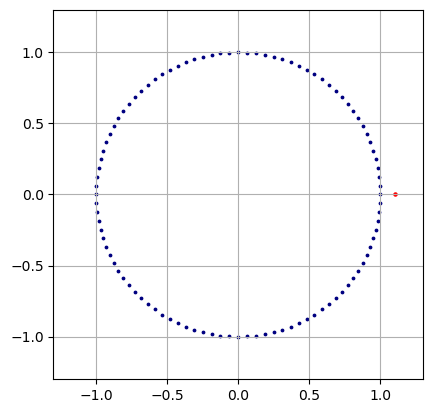

In [12]:
fig, ax = plt.subplots()

bent = ax.scatter(R*np.cos(phi[0,:]),R*np.sin(phi[0,:]), s=3, color='navy')
kint = ax.scatter(rho*np.cos(theta[0]),rho*np.sin(theta[0]), s=5, color='red')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
ax.set_aspect('equal')
ax.grid()

def update(frame):
    # for each frame, update the data stored on each artist.
    x1 = R*np.cos(phi[frame,:])
    y1 = R*np.sin(phi[frame,:])
    # update the scatter plot:
    data1 = np.stack([x1, y1]).T
    bent.set_offsets(data1)

    x2 = rho*np.cos(theta[frame])
    y2 = rho*np.sin(theta[frame])
    # update the scatter plot:
    data2 = np.stack([x2, y2]).T
    kint.set_offsets(data2)

    return (bent,kint),

ani = animation.FuncAnimation(fig=fig, func=update, frames=phi.shape[0], interval=1)

HTML(ani.to_jshtml())

Text(0.5, 1.0, 'A szögsebességek alakulása')

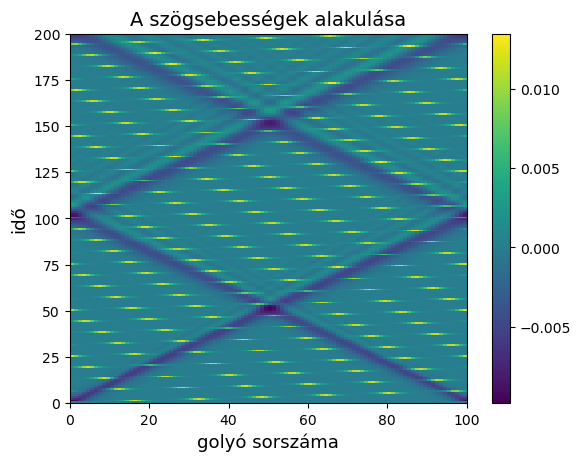

In [13]:
plt.pcolormesh(omega)
plt.colorbar()
plt.ylabel('idő', size=13)
plt.xlabel('golyó sorszáma', size=13)
plt.title('A szögsebességek alakulása', size=14)

In [14]:
v_b = R*omega

In [15]:
v_fft=np.abs(fft(ifft(v_b, axis=0),axis=1))
w=(fftfreq(len(t),t[1]-t[0]))
q=fftfreq(v_b.shape[1],1)

Text(0.5, 1.0, 'A sebesség FFT-ja')

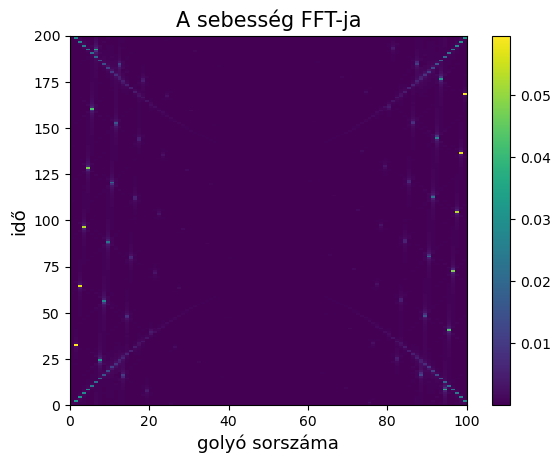

In [16]:
plt.pcolormesh(v_fft)

plt.colorbar()
plt.xlabel('golyó sorszáma',size=13)
plt.ylabel('idő',size=13)
plt.title('A sebesség FFT-ja',size=15)

In [17]:
def phonon_spectrum(omega,n,R):

    v_belso=R*omega
    kran_b = np.linspace(-np.pi, np.pi, n)
    wran_b = np.linspace(-np.pi/np.diff(t)[0],np.pi/np.diff(t)[0], len(t))
    plt.pcolormesh(kran_b, wran_b, np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fft(v_belso, axis=1),axis=0), axes=(1,0)))**2, norm=LogNorm())

    plt.ylim(0,3)
    plt.colorbar()
    plt.ylabel(r'$\omega$ körfrekvencia', size=13)
    plt.xlabel(r'$k$ hullámszám', size=13)
    plt.title(r'$\omega (k)$', size=14)

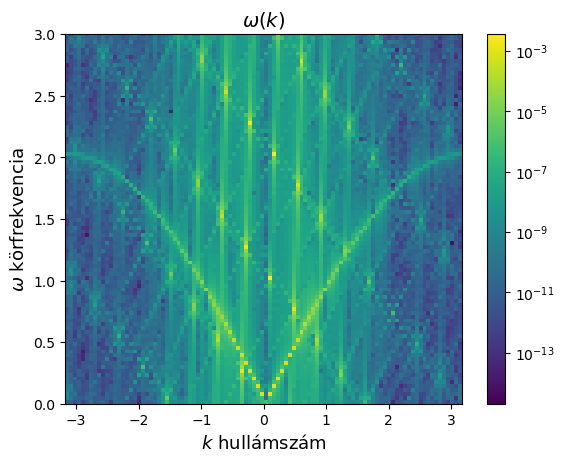

In [18]:
phonon_spectrum(omega,n,R)

## A külső golyó kinetikus energiája:

b-t változtatni

In [19]:
def k_tester(params,k_min,k_max,k_steps):
    """
    Bemenet:
    --paraméterek (m,R,d,rho,b)
    --minimum k
    --maximum k
    --k lépések száma
    """

    m,R,d,rho,b=params

    k_vals=np.linspace(k[0],k[1],k_steps)

    fig, axs = plt.subplots(k_steps, 2, figsize=(10, k_steps * 3))

    for i in range(k_steps):
        p=(d,m,R,rho,k_vals[i],b)
        u=odeint(diffeq,X_0,t,args=(p,))

        phi=u[:,:n]
        omega=u[:,n:2*n]
        theta=u[:,-2]
        Omega=u[:,-1]

        E_kin = 1/2 * m * rho**2 * Omega**2
        V = k_vals[i]*np.exp((-b)*(np.sqrt(R**2 + rho**2 - 2*R*rho*np.cos(theta[0]-phi[0,:]))))

        axs[i,0].plot(range(len(Omega)),E_kin, linewidth=1, label=f"{k_vals[i]:.3f}")
        axs[i,1].plot(range(phi.shape[1]),V, linewidth=1, label=f"{k_vals[i]:.3f}")
        axs[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axs[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axs[i,1].legend()
        axs[i,1].grid()
        axs[i,0].grid()
        axs[i,0].legend()

    axs[0,0].set_title('Kinetikus energia alakulása')
    axs[0,1].set_title('Kölcsönhatás erőssége')
    plt.tight_layout()
    plt.show()

In [20]:
def b_tester(params, b_min, b_max, b_steps):
    """
    Bemenet:
    --paraméterek [m,R,d,rho,k]
    --b minimum
    --b maximum
    --b lépések száma
    """

    m,R,d,rho,k=params
    
    b_vals=np.linspace(b_min, b_max, b_steps)

    fig, axs = plt.subplots(b_steps, 2, figsize=(10, b_steps * 3))

    for i in range(b_steps):
        b=b_vals[i]/(R+rho)
        p=(d,m,R,rho,k,b)
        u=odeint(diffeq,X_0,t,args=(p,))

        phi=u[:,:n]
        omega=u[:,n:2*n]
        theta=u[:,-2]
        Omega=u[:,-1]

        E_kin = 1/2 * m * rho**2 * Omega**2
        V = k*np.exp((-b)*(np.sqrt(R**2 + rho**2 - 2*R*rho*np.cos(theta[0]-phi[0,:]))))

        axs[i,0].plot(range(len(Omega)),E_kin, linewidth=1, label=f"{b_vals[i]:.3f}")
        axs[i,1].plot(range(phi.shape[1]),V, linewidth=1, label=f"{b_vals[i]:.3f}")
        axs[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axs[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axs[i,1].legend()
        axs[i,1].grid()
        axs[i,0].grid()
        axs[i,0].legend()

    axs[0,0].set_title('Kinetikus energia alakulása')
    axs[0,1].set_title('Kölcsönhatás erőssége')
    plt.tight_layout()
    plt.show()

In [21]:
test_params=params[:5]

In [22]:
#b_tester(test_params,10,20,10)

In [23]:
def En(params, phi, omega, theta, Omega):
    
    N=int(len(phi[0,:]))
    T=int(len(phi[:,0]))
    
    d,m,R,rho,k,b=params  #bejövő paraméterek
    l=2*R*np.sin(np.pi/(N)) #rugók nyugalmi hossza   
    
    phi_p1 = np.roll(phi,1)
    
    E=[]
    K_i=[]
    K_o=[]    
    K_elso=[]
        
    for t in range(T):
        V_in= 1/2 * d * (-1*R*np.sqrt(2)* np.sqrt(1-np.cos(phi[t,:]-phi_p1[t,:])) + l)**2
        V_out= k*np.exp(-1*b*np.sqrt(R**2-2*R*rho*np.cos(theta[t]-phi[t,:])+rho**2))
        K_in=1/2 * m * R**2 * omega[t,:]**2
        K_out=1/2 * m * Omega[t]**2 *rho**2

        K_i.append(np.sum(K_in))
        K_o.append(K_out)
        K_elso.append(K_in[0])
        
        E.append(np.sum(V_in+V_out+K_in)+K_out)
        
    E=np.array(E)
    K_i=np.array(K_i)
    K_o=np.array(K_o)
    K_elso=np.array(K_elso)
    
    return E,K_i,K_o,K_elso
    

## Futások mentése:

In [24]:
def save_run(name,u,params,n,o,T):
    header=[]
    for a in (*params,n,o,T):
        header.append(a)
    np.savetxt(f'{name}.txt',u, header=f'm,R,d,rho,b,n,o,T = {header}')

In [25]:
save_run('proba',u,params,n,o,T)

## Egy hosszú futás (T=10000):

In [26]:
hosszu_futas=np.loadtxt('hosszu_futas.txt', skiprows=1)

In [27]:
phi_h,omega_h,theta_h,Omega_h=solution_divider(hosszu_futas,100)

In [28]:
phi_h.shape

(10000, 100)

In [29]:
E,K_i,K_o,K_elso=En(params,phi_h,omega_h,theta_h,Omega_h)
E_avg=np.mean(E)
E_std=np.std(E)

In [30]:
print(f' Az összenergia átlagosan: {E_avg} ')
print(f' Az összenergia szórása: {E_std}')

 Az összenergia átlagosan: 0.66467156771582 
 Az összenergia szórása: 1.93966631303173e-05


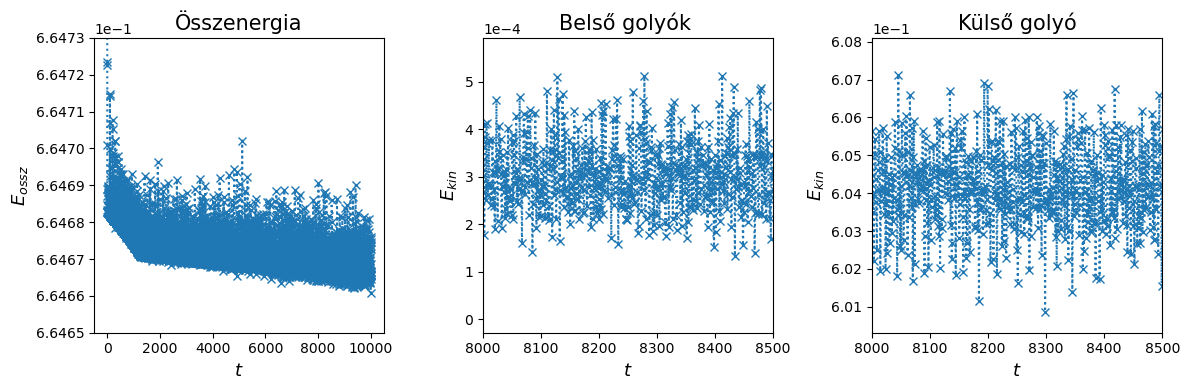

In [31]:
fig,ax=plt.subplots(1,3, figsize=(12,4))

ax[0].plot(range(len(E)),E, marker='x', linestyle=':')
ax[0].set_title('Összenergia', size=15)
ax[0].set_ylabel(r'$E_{ossz}$', size=13)
ax[0].set_xlabel(r'$t$', size=13)
#ax[0].set_xlim(0,1000)
ax[0].set_ylim(6.6465*1e-1, 6.6473*1e-1)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[1].set_title('Belső golyók ',size=15)
ax[1].plot(range(len(K_i)),K_i, marker='x', linestyle=':')
ax[1].set_ylabel(r'$E_{kin}$', size=13)
ax[1].set_xlabel(r'$t$', size=13)
ax[1].set_xlim(8000,8500)
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax[2].set_title('Külső golyó',size=15)
ax[2].plot(range(len(K_o)),K_o, marker='x', linestyle=':')
ax[2].set_ylabel(r'$E_{kin}$', size=13)
ax[2].set_xlabel(r'$t$', size=13)
ax[2].set_xlim(8000,8500)
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.tight_layout()

(8000.0, 8500.0)

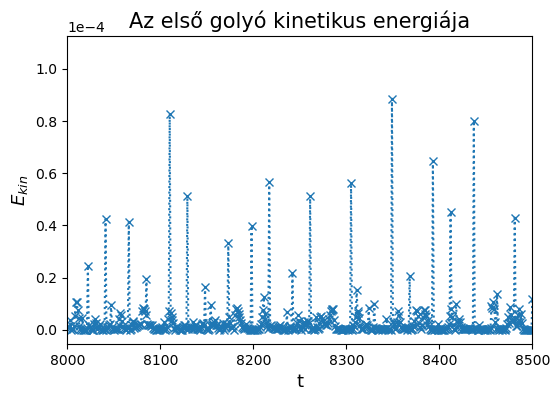

In [32]:
fig,ax=plt.subplots(figsize=(6,4))
plt.plot(range(len(K_elso)), K_elso, marker='x', linestyle=':')
plt.xlabel('t', size=13)
plt.ylabel(r'$E_{kin}$', size=13)
plt.title('Az első golyó kinetikus energiája', size=15)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlim(8000,8500)